In [20]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
from tensorflow.keras import metrics
import pandas as pd
from loss_functions import sigma_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma, mse_batch, sigma_f_loss
import math
import useful_functions as uf
import NN_functions as nuf
import os, shutil

seed_train=40
np.random.seed(seed_train)# i set a random seed for the generation of the maps for reproducibility
tf.random.set_seed(seed_train)#the seed for tensorflow operation is different from the seed for numpy operations

#map gen
nside = 16
n_train=100 #the total number of training+validation pair of maps that i will generate
n_train_fix=100 #the total number of of training maps i will spread on all the r interval -> for each r value i generate n_train_fix/len(r) maps 
kind_of_map="BB"
n_channels=2
pol=1
res=hp.nside2resol(nside, arcmin=False) 
sensitivity=4

reduce_lr_on_plateau = True
p_stopping=20
p_reduce=5
f_reduce=0.5
stopping_monitor="val_loss"
reduce_monitor="val_loss"
metrics=[]
base_dir="None"

#network structure
one_layer=True # this is to switch between one dense layer or two dense layer
drop=0.2
n_layers=3
nodes_per_layer=[256, 128, 128]
if kind_of_map!="QU": 
    n_inputs=n_channels
else:
    n_inputs=pol*n_channels
n_output=1

#train and val
batch_size = 16
max_epochs = 20
lr=0.001
fval=0.1 # this is the fraction of data that i use for validation, computed on n_train_fix
training_loss="mse"
loss_training=tf.keras.losses.MeanSquaredError() # this is the loss i use for the training
shuffle=True
norm=True
map_norm=True #False
batch_ordering=False #True
distr=1

f_ = np.load('/home/amorelli/cl_generator/outfile_R_000_001_seed=67.npz') 
#print("outfile_R:",f_.files) #give the keiwords for the stored arrays
labels=f_.files
data=f_[labels[0]]
r=f_[labels[1]]
r, data=uf.unison_sorted_copies(r, data)
indexes=np.linspace(0,len(r)-1,10,dtype=int)
r=r[indexes]
data=data[indexes]

#input_folder="/home/amorelli/foreground_noise_maps/noise_generation"
#input_files=os.listdir(input_folder)
#for i in range(len(input_files)):
   # input_files[i]=input_folder+"/"+input_files[i]
noise_maps=uf.generate_noise_maps(n_train,n_channels,nside,pol=1,sensitivity=sensitivity,input_files=None)

#noise_E,noise_B=uf.convert_to_EB(noise_maps)

maps_per_cl_gen=uf.maps_per_cl(distribution=distr)
maps_per_cl=maps_per_cl_gen.compute_maps_per_cl(r,n_train,n_train_fix)

mappe_B,y_r=uf.generate_maps(data, r,n_train=n_train,nside=nside, map_per_cl=maps_per_cl, 
                             noise_maps=noise_maps, beam_w=2*res, kind_of_map=kind_of_map, 
                             raw=0 , n_channels=n_channels,beam_yes=1 , verbose=0)


x_train,y_train,x_val,y_val = nuf.prepare_data(y_r,mappe_B,r,n_train,n_train_fix,fval,maps_per_cl
                                               , batch_size, batch_ordering=batch_ordering)

if norm:
    y_train=nuf.normalize_data(y_train,r)
    y_val=nuf.normalize_data(y_val,r)

if map_norm:
    for i in range(len(x_train)):
        for j in range(n_inputs):
            x=x_train[i,:,j]
            x_train[i,:,j]=nuf.normalize_data(x,x)
    for i in range(len(x_val)):
        for j in range(n_inputs):
            x=x_val[i,:,j]
            x_val[i,:,j]=nuf.normalize_data(x,x)

model=nuf.build_network(n_inputs,nside,n_layers=n_layers,layer_nodes=nodes_per_layer,num_output=n_output,
                        use_normalization=[False,False,True],use_drop=[False,True,False],
                        drop=[drop,drop,drop],activation_dense="relu",kernel_initializer="he_normal")
print(model.summary())

history=nuf.compile_and_fit(model, x_train, y_train, x_val, y_val, batch_size, max_epochs, 
                            stopping_monitor,p_stopping,reduce_monitor,f_reduce, p_reduce,base_dir, loss_training,lr,
                            metrics,shuffle=shuffle,verbose=2,callbacks=[False,False,False,False,True],append=False,n_optimizer=0)
#[early_stopping,reduce_lr,csv_logger,model_checkpoint_callback,increase_lr]

predictions_train=model.predict(x_train)

predictions_val=model.predict(x_val)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072, 2)]         0         
                                                                 
 order_map (OrderMap)        (None, 27648, 2)          0         
                                                                 
 conv1d (Conv1D)             (None, 3072, 32)          576       
                                                                 
 activation (Activation)     (None, 3072, 32)          0         
                                                                 
 order_map_1 (OrderMap)      (None, 3072, 32)          0         
                                                                 
 average_pooling1d (AverageP  (None, 768, 32)          0         
 ooling1D)                                                       
                                                             

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072, 2)]         0         
                                                                 
 order_map (OrderMap)        (None, 27648, 2)          0         
                                                                 
 conv1d (Conv1D)             (None, 3072, 32)          576       
                                                                 
 activation (Activation)     (None, 3072, 32)          0         
                                                                 
 order_map_1 (OrderMap)      (None, 3072, 32)          0         
                                                                 
 average_pooling1d (AverageP  (None, 768, 32)          0         
 ooling1D)                                                       
                                                             

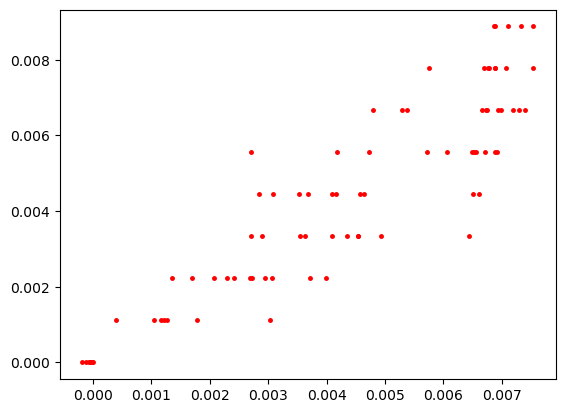

In [14]:
predictions_train=nuf.denormalize_data(predictions_train,r)
predictions_val=nuf.denormalize_data(predictions_val,r)
y_train=nuf.denormalize_data(y_train,r)
import matplotlib.pyplot as plt
plt.plot(predictions_train,y_train,linestyle='None',marker='.', markersize = 5.0,color="red")

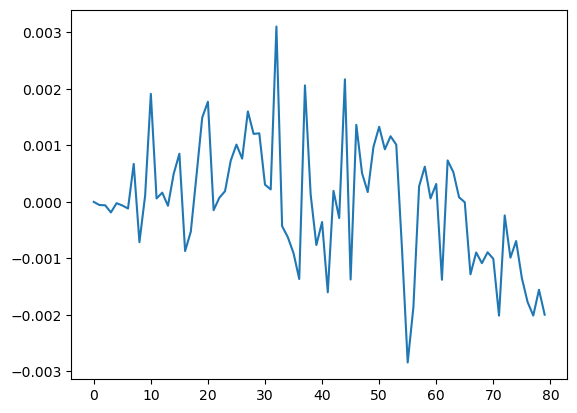

In [15]:
plt.plot(range(len(predictions_train)),predictions_train-y_train)
#print(y_train)

In [16]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072, 2)]         0         
                                                                 
 order_map (OrderMap)        (None, 27648, 2)          0         
                                                                 
 conv1d (Conv1D)             (None, 3072, 32)          576       
                                                                 
 activation (Activation)     (None, 3072, 32)          0         
                                                                 
 order_map_1 (OrderMap)      (None, 3072, 32)          0         
                                                                 
 average_pooling1d (AverageP  (None, 768, 32)          0         
 ooling1D)                                                       
                                                             